In [79]:
import numpy as np
import pandas as pd

from utils.timeutil import YearMonth

hst = pd.read_csv(".cache/historical_data.csv", dtype={"code": str})
hst["매수년월"] = hst["매수년월"].apply(lambda x: YearMonth.from_string(x))
hst["매도년월"] = hst["매도년월"].apply(lambda x: YearMonth.from_string(x))
hst = hst[hst["확정실적"].notna()]

In [80]:
# RECIPE ==========================================================

recipes = {
    "벨류": {
        "GP/P": 0.120550,
        "EQ/P": 0.105678,
    },
    "성장": {
        "O_QoQ": 0.027,
        "E_QoQ": 0.024,
        "EBT_QoQ": 0.017,
        "O/A_QoQ": 0.013,
        "E/EQ_QoQ": 0.011,
        "O/EQ_QoQ": 0.01,
        "E/A_QoQ": 0.009,
        "EBT/A_QoQ": 0.008,
        "EBT/EQ_QoQ": 0.006,
        "GP/EQ_QoQ": 0.004,
        "GP/A_QoQ": 0.004,
        "GP_QoQ": 0.003,
        "R_QoQ": 0.001,
        "R/EQ_QoQ": 0.001,
        "R/A_QoQ": 0.001,
    },
    "가격": {
        "P": -1
    },
    "전략": {
        "성장": 1,
        "벨류": 1,
        "가격": 1
    }
}

# =================================================================

pct_scale = 100
for title, recipe in recipes.items():
    # Calculate recipe
    hst[title] = hst.apply(lambda row: sum([row[f"{k}_pct"] * w for k, w in recipe.items()]), axis=1)

    # Calculate pct
    rank = hst.groupby("매도년월")[title].apply(lambda x: np.ceil(x.rank(pct=True) * pct_scale))
    hst[f"{title}_pct"] = rank.reset_index(level=0, drop=True)

hst

,code,매수년월,매도년월,종목명,매수일,매수가,P,vol,val,shares,...,E/EQ_pct,E/R_pct,벨류,벨류_pct,성장,성장_pct,가격,가격_pct,전략,전략_pct
0,000020,2014-04,2014-05,동화약품,2014-04-30,6000.0,1.675888e+11,1566607.0,9.163852e+09,27931470.0,...,30.0,32.0,18.308022,88.0,6.819,52.0,-66.0,35.0,175.0,68.0
1,000040,2014-04,2014-05,KR모터스,2014-04-30,1245.0,1.485800e+11,118231719.0,1.300651e+11,119341379.0,...,16.0,16.0,2.217664,5.0,10.297,76.0,-63.0,39.0,120.0,29.0
2,000050,2014-04,2014-05,경방,2014-04-30,133500.0,3.659939e+11,35866.0,4.863769e+09,2741527.0,...,38.0,62.0,15.025002,72.0,10.752,81.0,-81.0,20.0,173.0,66.0
4,000070,2014-04,2014-05,삼양홀딩스,2014-04-30,72000.0,5.882735e+11,108108.0,7.798089e+09,8170465.0,...,27.0,26.0,20.256416,94.0,7.243,55.0,-87.0,14.0,163.0,58.0
5,000080,2014-04,2014-05,하이트진로,2014-04-30,25000.0,1.753340e+12,5784461.0,1.413551e+11,70133611.0,...,54.0,62.0,14.188154,67.0,12.185,94.0,-93.0,8.0,169.0,63.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252300,950140,2024-01,2024-02,잉글우드랩,2024-01-31,13620.0,2.706003e+11,3312395.0,4.840918e+10,19867866.0,...,90.0,81.0,6.347682,23.0,12.105,93.0,-73.0,29.0,145.0,44.0
252301,950160,2024-01,2024-02,코오롱티슈진,2024-01-31,11690.0,8.499272e+11,5701386.0,6.613644e+10,72705495.0,...,19.0,3.0,1.025462,2.0,4.548,31.0,-89.0,12.0,45.0,3.0
252303,950190,2024-01,2024-02,고스트스튜디오,2024-01-31,13000.0,1.765386e+11,2060342.0,2.692313e+10,13579892.0,...,96.0,97.0,11.957192,54.0,8.862,66.0,-61.0,41.0,161.0,56.0
252304,950200,2024-01,2024-02,소마젠,2024-01-31,4980.0,9.579554e+10,1306206.0,7.337752e+09,19236053.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-41.0,62.0,NaN,NaN


In [81]:
def pnl_by_pct(factor: str): return (
    hst
    .groupby(["매도년월", f"{factor}_pct"])["수익률"]
    .mean()
    .to_frame()
    .reset_index()
    .pivot(index="매도년월", columns=f"{factor}_pct")
    .droplevel(level=0, axis=1)
)


def agg_by_pct(factor: str):
    """
    cagr, mdd by factor
    """
    df = pnl_by_pct(factor)
    years = df.index.min().duration(df.index.max())
    cum = (df + 1).cumprod()
    dd = cum / cum.cummax() - 1
    return pd.DataFrame({
        "cagr": (df + 1).prod() ** (1 / years) - 1,
        "mdd": dd.min(),
    })


returns_bm = hst.groupby("매도년월")["수익률"].mean()


def agg_by_month(factor: str, port_size: int):
    """
    """
    returns_top = (
        hst
        .groupby("매도년월")
        .apply(
            lambda x: x.nlargest(port_size, f"{factor}_pct")["수익률"].mean(),
            include_groups=False
        )
    )

    df = pnl_by_pct(factor)
    return pd.DataFrame({
        "port": returns_top,
        "bm": returns_bm,
        "perform": returns_top - returns_bm,
        "corr": df.apply(lambda x: x.corr(pd.Series(x.index)), axis=1),
    })


def calc_performance(factor: str):
    df = agg_by_pct(factor)
    corr = df.reset_index().corr("spearman").loc[f"{factor}_pct", "cagr"]
    coef, _ = np.polyfit(df.index, df["cagr"], 1)
    return pd.Series({
        "factor": factor,
        "corr": corr,
        "coef": coef,
        "power": corr * coef
    })


In [82]:
"""모든 팩터 성능 측정"""

all_factors = [col.split("_pct")[0] for col in hst.columns if col.endswith("_pct")]

(
    pd.Series(all_factors)
    .apply(calc_performance)
    .sort_values("power", ascending=False)
    .reset_index(drop=1)
)

,factor,corr,coef,power
0,수익률,1.000000,0.914873,9.148730e-01
1,전략,0.930453,0.003867,3.597819e-03
2,P,-0.800540,-0.003984,3.189739e-03
3,val,-0.873195,-0.003373,2.945262e-03
4,가격,0.764800,0.003661,2.800059e-03
5,성장,0.790891,0.001666,1.317321e-03
6,O_QoQ,0.744170,0.001611,1.198931e-03
7,벨류,0.700834,0.001698,1.190273e-03
8,O/EQ_QoQ,0.714683,0.001538,1.098857e-03
9,O/A_QoQ,0.687501,0.001569,1.078365e-03


In [83]:
target_factor = "전략"

<BarContainer object of 100 artists>

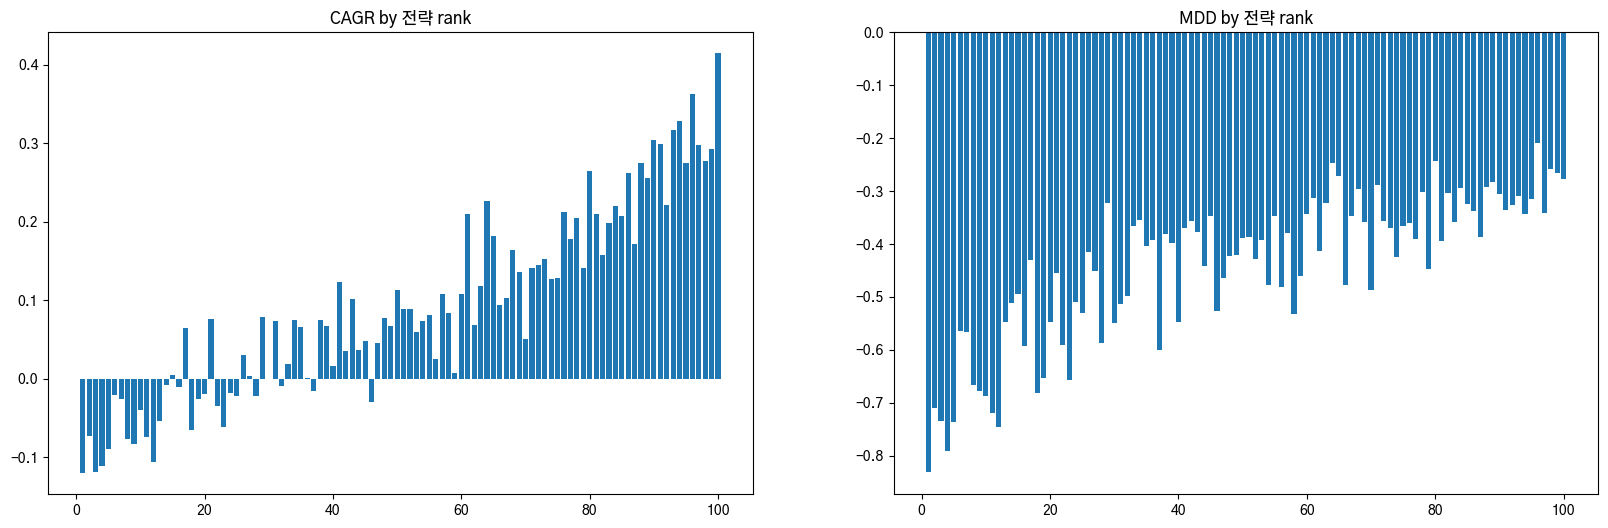

In [84]:
"""팩터 성능"""

import matplotlib.pyplot as plt
from matplotlib import font_manager

font_path = '../res/font/Gothic_A1/GothicA1-Medium.ttf'
font_manager.fontManager.addfont(font_path)
font_name = font_manager.fontManager.ttflist[-1].name
plt.rc("font", family=font_name)
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
plt.rcParams['agg.path.chunksize'] = 10_000

agg = agg_by_pct(target_factor)

n_rows, n_cols = 1, 2
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)
fig.set_figwidth(20), fig.set_figheight(6 * n_rows)

axes[0].set_title(f"CAGR by {target_factor} rank")
axes[0].bar(agg.index, agg["cagr"])

axes[1].set_title(f"MDD by {target_factor} rank")
axes[1].bar(agg.index, agg["mdd"])

,port,bm,perform,corr
매도년월,,,,
2014-05,0.024295,-0.001313,0.025608,0.465650
2014-06,-0.002396,-0.008577,0.006182,0.148386
2014-07,0.102626,0.019002,0.083624,0.309549
2014-08,0.093638,0.039388,0.054250,0.035734
2014-09,0.090935,0.011842,0.079092,0.218791
...,...,...,...,...
2023-10,-0.034690,-0.084423,0.049733,0.684809
2023-11,0.030877,0.089897,-0.059020,-0.347964
2023-12,0.009552,0.029914,-0.020362,-0.139678


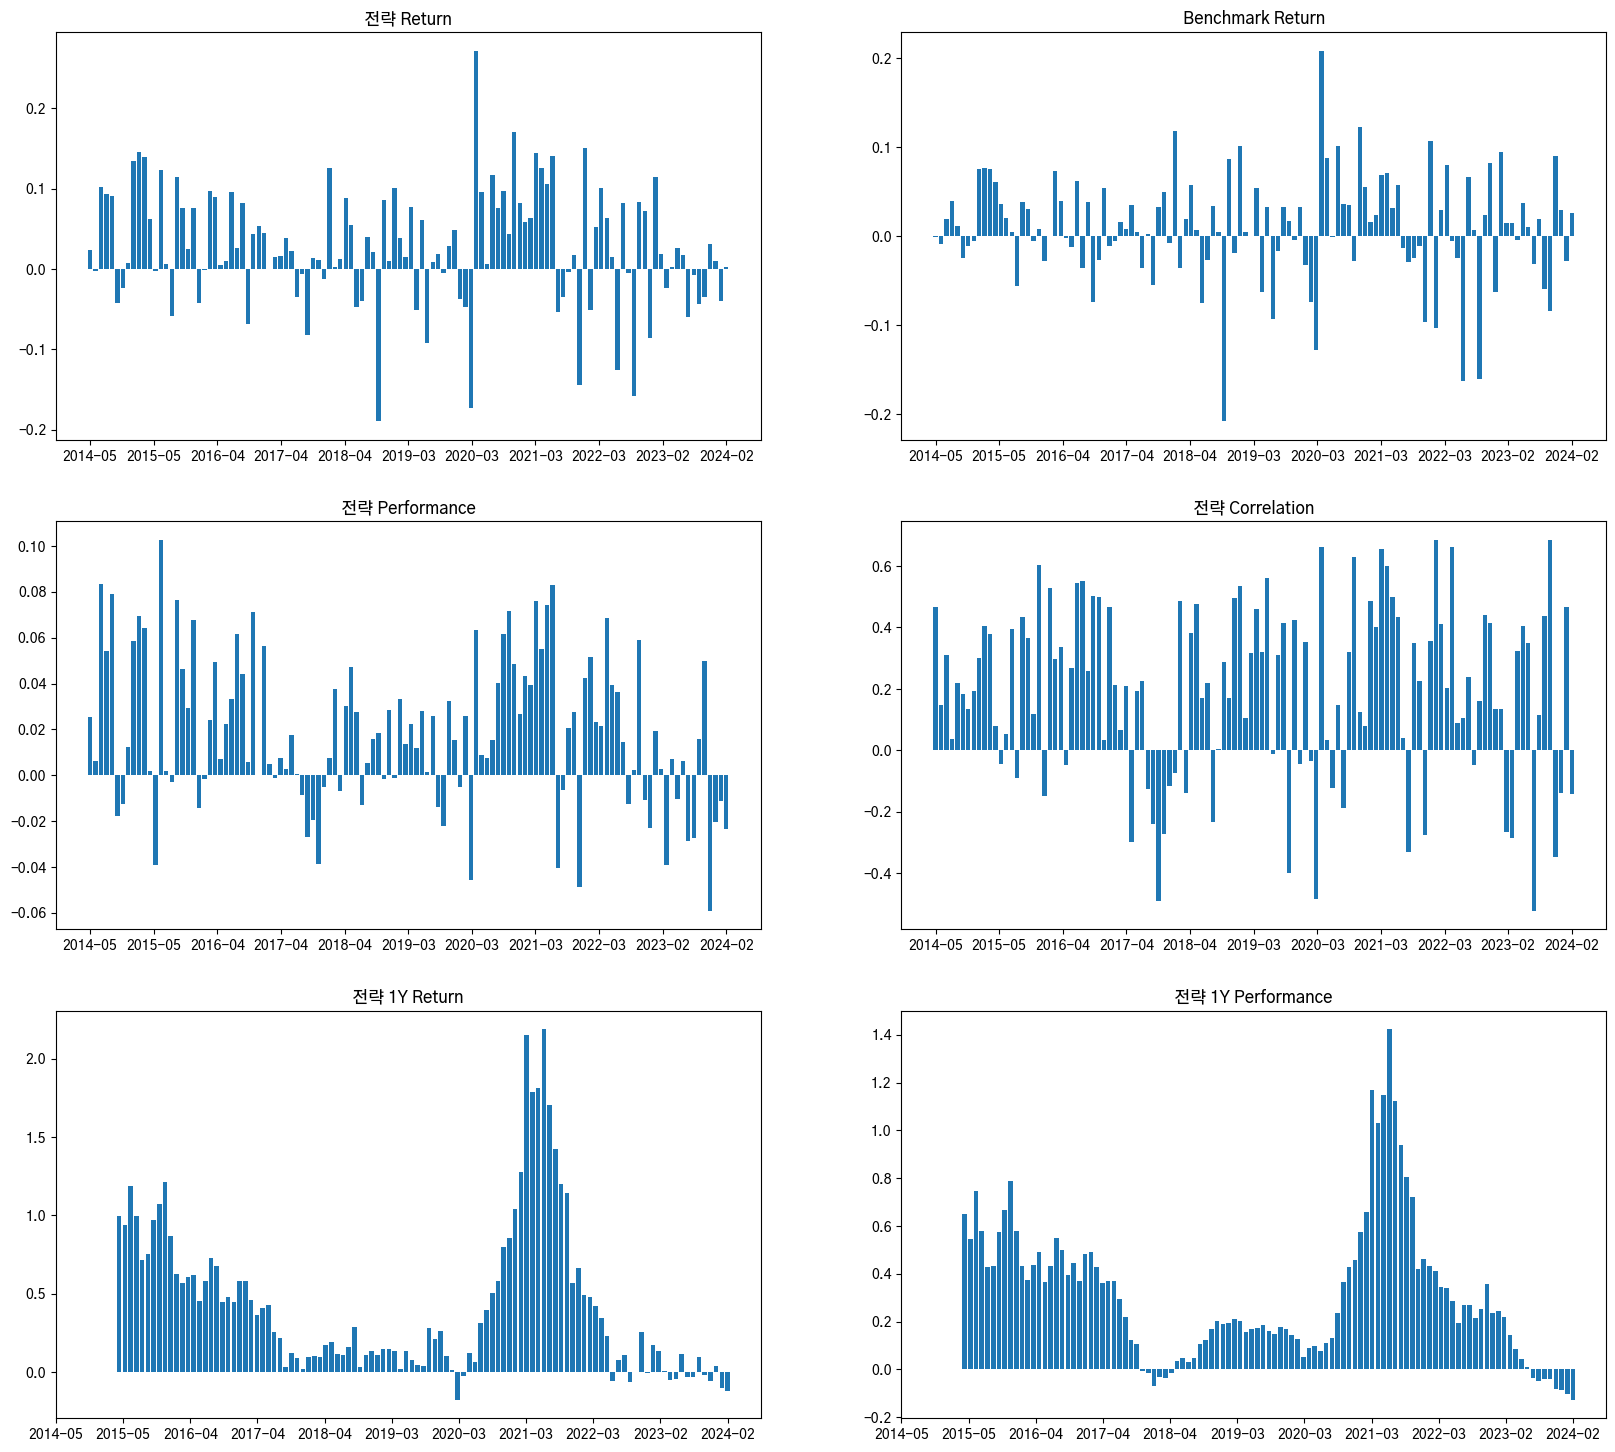

In [85]:
"""
월별 팩터 성능
"""

n_rows, n_cols = 3, 2
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols)
fig.set_figwidth(20), fig.set_figheight(6 * n_rows)

agg = agg_by_month(target_factor, 40)

x_ticks = np.quantile(np.arange(0, len(agg)), [1 * i / 10 for i in range(10)] + [1])
x_values = [str(x) for x in agg.index]

axes[0][0].set_title(f"{target_factor} Return")
axes[0][0].bar(x_values, agg["port"])
axes[0][0].set_xticks(x_ticks)

axes[0][1].set_title(f"Benchmark Return")
axes[0][1].bar(x_values, agg["bm"])
axes[0][1].set_xticks(x_ticks)

axes[1][0].set_title(f"{target_factor} Performance")
axes[1][0].bar(x_values, agg["perform"])
axes[1][0].set_xticks(x_ticks)

axes[1][1].set_title(f"{target_factor} Correlation")
axes[1][1].bar(x_values, agg["corr"])
axes[1][1].set_xticks(x_ticks)

# 전략 1년 누적 수익률
rolling_port = agg["port"].rolling(window=12).apply(lambda x: (x + 1).prod() - 1)
axes[2][0].set_title(f"{target_factor} 1Y Return")
axes[2][0].bar(x_values, rolling_port)
axes[2][0].set_xticks(x_ticks)

# 전략 1년 누적 성능
rolling_perform = rolling_port - agg["bm"].rolling(window=12).apply(lambda x: (x + 1).prod() - 1)
axes[2][1].set_title(f"{target_factor} 1Y Performance")
axes[2][1].bar(x_values, rolling_perform)
axes[2][1].set_xticks(x_ticks)

# round(df * 100, 2)
agg

In [86]:
# 월별 포트 구성
port = (
    hst
    .groupby("매도년월")
    .apply(lambda x: x.nlargest(20, f"{target_factor}_pct").sort_values("수익률"), include_groups=False)
    .droplevel(level=1)
    [["code", "종목명", "매수일", "매도일", "수익률", "매수가", "매도가"] + [f"{f}_pct" for f in recipes[target_factor].keys()]]
)
port.reset_index(drop=True).to_csv(".cache/port.csv")
port

,code,종목명,매수일,매도일,수익률,매수가,매도가,성장_pct,벨류_pct,가격_pct
매도년월,,,,,,,,,,
2014-05,057880,토필드,2014-04-30,2014-05-30,-0.112565,1910.0,1695.0,87.0,86.0,93.0
2014-05,091440,텔레필드,2014-04-30,2014-05-30,-0.097070,2730.0,2465.0,88.0,83.0,96.0
2014-05,002870,신풍제지,2014-04-30,2014-05-30,-0.058065,9300.0,8760.0,90.0,95.0,88.0
2014-05,006200,한국전자홀딩스,2014-04-30,2014-05-30,-0.032864,1065.0,1030.0,92.0,98.0,89.0
2014-05,008470,부스타,2014-04-30,2014-05-30,-0.025556,4500.0,4385.0,97.0,77.0,84.0
...,...,...,...,...,...,...,...,...,...,...
2024-02,095910,에스에너지,2024-01-31,2024-02-29,0.017505,1828.0,1860.0,78.0,96.0,94.0
2024-02,028080,휴맥스홀딩스,2024-01-31,2024-02-29,0.027673,3975.0,4085.0,89.0,100.0,86.0
2024-02,052300,씨티프라퍼티,2024-01-31,2024-02-29,0.127563,439.0,495.0,87.0,96.0,85.0


In [100]:
pnl_by_code = port.groupby(["code", "종목명"]).agg(
    count=pd.NamedAgg(column="수익률", aggfunc="size"),
    평균수익률=pd.NamedAgg(column="수익률", aggfunc="mean"),
    누적수익률=pd.NamedAgg(column="수익률", aggfunc="mean")
)
pnl_by_code.to_csv(".cache/pnl_by_code.csv")
pnl_by_code

,,count,평균수익률,누적수익률
code,종목명,,,
000300,대유플러스,2,-0.088913,-0.088913
000440,중앙에너비스,4,0.026443,0.026443
000500,가온전선,1,0.050314,0.050314
000520,삼일제약,19,0.007148,0.007148
000590,CS홀딩스,3,0.011702,0.011702
...,...,...,...,...
900260,로스웰,10,-0.025859,-0.025859
900270,헝셩그룹,8,-0.017644,-0.017644
900280,골든센츄리,1,0.146853,0.146853
